# Tarea 4: Optimización 

## Oscar Esaú Peralta Rosales


Select from train set[0] and train set[1] the set of observations $S = \{(x_i, y_i\}$ with $x_i ∈ R^{784}$ and $y_i ∈ \{0, 1\}$ and estimate the parameters $\beta,\ \beta_0$ that maximizes the function

$$
h(\beta, \beta_0)= \sum_{i=1}^{n} y_i log\pi_i + (1-y_i)log(1-\pi_i)
$$

$$
pi_i:= pi_i(\beta, \beta_0) = \frac{1}{1 + \exp(-x_i^T \beta - \beta_0)}
$$

using the set $S$. Select one optimization method implemented in the home-
work for computing $\beta, \beta_0$.

Select from test $set[0]$ and test $set[1]$ the set $T = {(x_i , y_i )}$ such that $x_i \in R^{784}$ and $y_i ∈ {0, 1}$ and compute the error

$$
error = \frac{1}{|\tau|} \sum_{x_i,y_i \in \tau} |1_{\pi_i(\beta, \beta_0) > 0.5} (x_i) - y_i|
$$

where $|\tau|$ represents the number of elements of the set $\tau$.



## Lectura de datos

In [0]:
%matplotlib inline

In [0]:
import time

from typing import Callable, Dict, Tuple
from collections import namedtuple

import numpy as np
import matplotlib.pyplot as plt


In [0]:
import gzip, pickle
with gzip.open('mnist.pkl.gz','rb') as ff :
    u = pickle._Unpickler( ff )
    u.encoding = 'latin1'
    train, val, test = u.load()


print( train[0].shape, train[1].shape )
print( val[0].shape, val[1].shape )
print( test[0].shape, test[1].shape )

(50000, 784) (50000,)
(10000, 784) (10000,)
(10000, 784) (10000,)


clase:  3


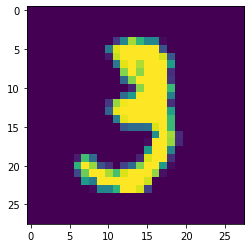

In [0]:
idimg = 10

im =  train[0][idimg,:].reshape(-1, 28) 

plt.imshow(im)
print('clase: ', train[1][idimg])

## Select data

In [0]:
def select_01(data, normalize=False):
    index_data = np.logical_or(data[1] == 0, data[1] == 1)
    x = data[0][index_data]
    y = data[1][index_data]
    
    if normalize:
        x /= np.linalg.norm(x, axis=1)[:,None]

    return x, y

In [0]:
x_train, y_train = select_01(train, normalize=False)
x_train.shape, y_train.shape

((10610, 784), (10610,))

In [0]:
x_val, y_val = select_01(val, normalize=False)
x_val.shape, y_val.shape

((2055, 784), (2055,))

In [0]:
x_test, y_test = select_01(test, normalize=False)
x_test.shape, y_test.shape

((2115, 784), (2115,))

## Función

In [0]:


def pi(w, theta):
    return 1.0 / (1.0 + np.exp(- w @ theta))

def f(theta, w, y, eps=1e-16):
    _pi = pi(w, theta)
    _pi2 = 1 - _pi

    _pi[_pi == 0] = eps
    _pi2[_pi2 == 0] = eps
    
    return - np.sum( y * np.log(_pi) + (1.0 - y) * np.log(_pi2) )


def f_grad(theta, w, y, eps=1.0):
    _pi = pi(w, theta)
    _pi2 = 1 - _pi

    return - np.sum((y * (_pi2) * w.T  - (1.0 - y) * _pi * w.T), axis=1)
    

In [0]:
def to_w(x):
    w = np.zeros((x.shape[0], x.shape[1]+1), dtype=float)
    for index in range(w.shape[0]):
        w[index] = np.concatenate((x[index], [1.0]))
    return w

In [0]:
w = to_w(x_train)

In [0]:
print(w.shape)
w[:,784]

(10610, 785)


array([1., 1., 1., ..., 1., 1., 1.])

In [0]:
beta = np.ones(w.shape[1])

In [0]:
f(beta, w, y_train, eps=1e-6)

68138.0980718824

In [0]:
g = f_grad(beta, w, y_train, eps=1)

In [0]:
g.shape

(785,)

In [0]:
np.linalg.norm(g)

41007.38226937714

## Barzilain

In [0]:
def barzilai_borwein(X: np.array,
                     f: Callable[[np.array], np.array],
                     g: Callable[[np.array], np.array],
                     tol_x: float=1e-12,
                     tol_g: float=1e-12,
                     tol_f: float=1e-12,
                     mxitr: int=100,
                     **kwargs):
    Result = namedtuple('Result', 'x_log f_log g_norm_log')

    # History of values computed
    # x_log = []; f_log = []
    # stop_x_log = []; stop_f_log = []; stop_g_log = []

    x_log = []
    f_log = []
    g_norm_log = []

    x_k_prev = None; 
    x_k = X;
    x_log.append(x_k)

    g_k_prev = None
    g_k = g(x_k, **kwargs.get('g_kwargs', {}))
    g_norm_log.append(np.linalg.norm(g_k))

    f_k = f(x_k, **kwargs.get('f_kwargs', {}))
    f_log.append(f_k)

    k = 0
    alpha_k = kwargs.get('alpha', 1e-2)
    
    while np.linalg.norm(g_k) > tol_g and k < mxitr:
        if k == 0:
            # h_k = H(x_k, **kwargs.get('g_kwargs', {}))
            # alpha_k = (g_k @ g_k) / (g_k @ h_k @ g_k)
            pass
        else:
            s_k1 = x_k - x_k_prev
            y_k1 = g_k - g_k_prev
            alpha_k = np.dot(s_k1, y_k1) / np.dot(y_k1, y_k1)
            # print(k, 'alpha', alpha_k)
        
        x_k_prev = x_k.copy()
        x_k = x_k_prev - alpha_k * g_k
        x_log.append(x_k)

        g_k_prev = g_k
        g_k = g(x_k, **kwargs.get('g_kwargs', {}))
        g_norm_log.append(np.linalg.norm(g_k))

        f_k = f(x_k, **kwargs.get('f_kwargs', {}))
        f_log.append(f_k)

        # Stop criteria
        # if stop_x(x_log[-2], x_log[-1]) <= tol_x or stop_f(f_log[-2], f_log[-1]) <= tol_f:
        #     break

        k += 1

    return Result(np.array(x_log), np.array(f_log), np.array(g_norm_log))


343 343 343


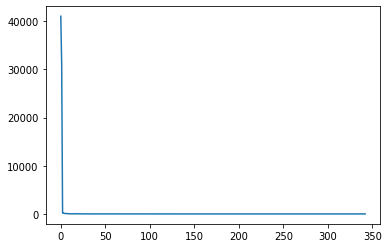

In [0]:
w = to_w(x_train)
beta = np.ones(w.shape[1])

_lambda = 1
params = {
    'X': beta,
    'f': f,
    'f_kwargs': {
        'w': w,
        'y': y_train,
        'eps': 1e-16
    },
    'g': f_grad,
    'g_kwargs': {
        'w': w,
        'y': y_train
    },
    'tol_x': 1e-12,
    'tol_f': 1e-12,
    'tol_g': 1e-12,
    'alpha': 1e-3,
    'mxitr': 10000
}

ans = barzilai_borwein(**params)

print(len(ans.x_log), len(ans.f_log), len(ans.g_norm_log))
# print(ans.x_log[-1])
plt.plot(ans.g_norm_log)
# plt.plot(ans.f_log)

In [0]:
ans.g_norm_log[-1]

9.786370663415539e-13

## Error

In [0]:
def aprox_error(x, y, beta):
    w = to_w(x)
    _pi = pi(w, beta)
    return np.mean(np.abs((_pi > 0.5) - y))

Error de clasificación

In [0]:
aprox_error(x_test, y_test, ans.x_log[-1])

0.00047281323877068556

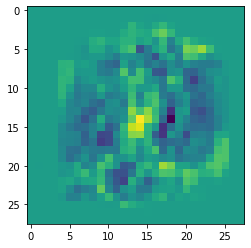

In [0]:
sol = np.array(ans.x_log[-1][:-1])
im =  sol.reshape(-1, 28) 
plt.imshow(im)

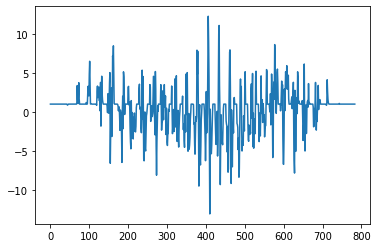

In [0]:
sol = np.array(ans.x_log[-1][:-1])
plt.plot(sol)